# Resultados para apoio a decisão de gestores públicos

## Área desmatada por municípios

In [2]:
import pandas as pd
import matplotlib.pyplot as plt

# Carregar os dados do CSV
path = 'D:/Projetos/Agronomiq/Teste_Adm/'
csv_file = f"{path}focos-desmatamento.csv"
df = pd.read_csv(csv_file)

In [3]:
# Agrupar por município e somar as áreas desmatadas
area_por_municipio = df.groupby('name')['area_km2'].sum().reset_index()

# Selecionar os 30 primeiros municipios
top_30_municipios = area_por_municipio.sort_values(by='area_km2', ascending=False).head(30)


### Para melhor representação dos resultados, devido ao grande número de municípios, foi selecionados os 30 com maiores áreas de desmatamento

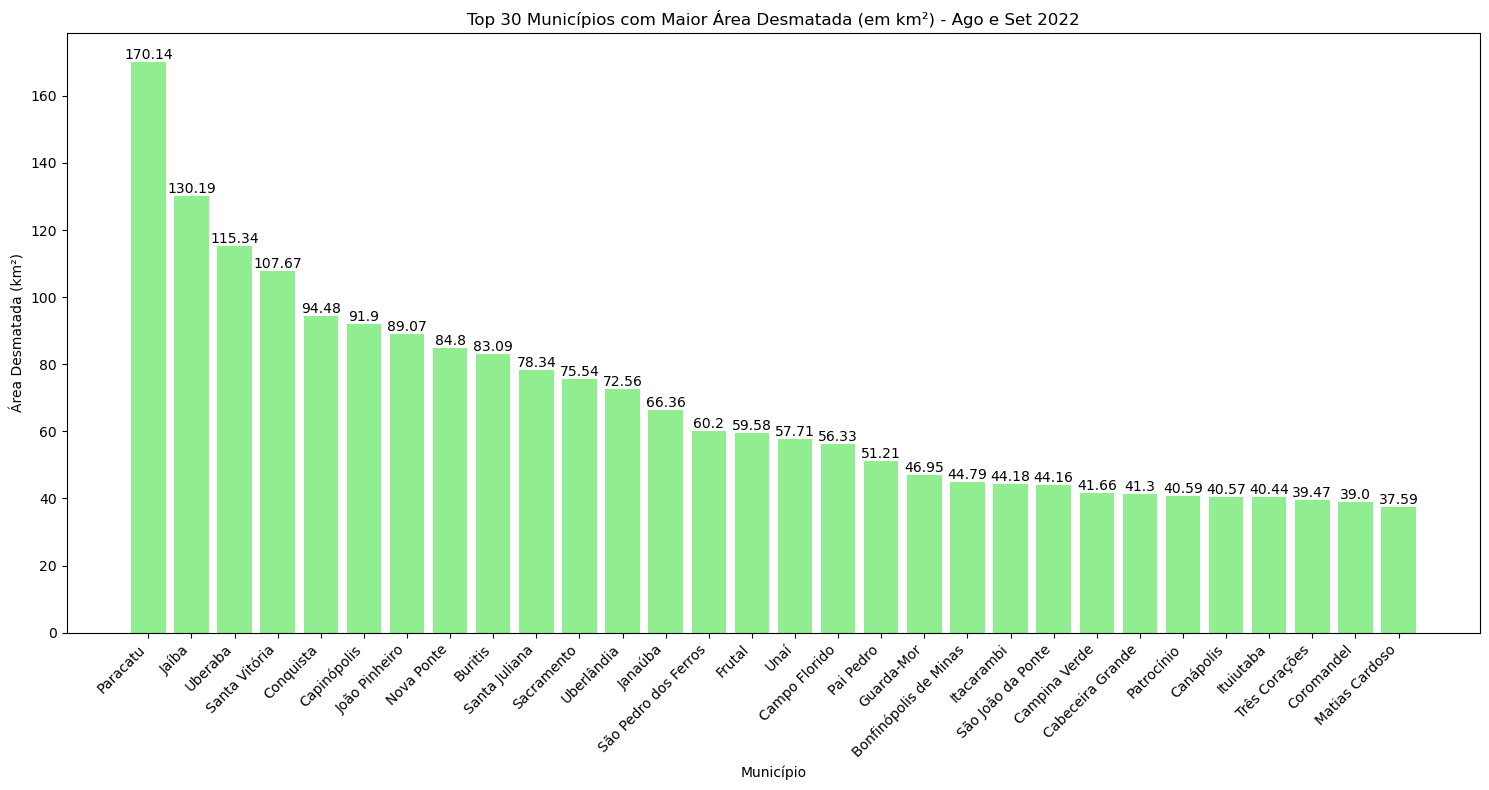

In [4]:
plt.figure(figsize=(15, 8))
bars = plt.bar(top_30_municipios['name'], top_30_municipios['area_km2'], color='lightgreen')

for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval, round(yval, 2), va='bottom', ha='center')

plt.title('Top 30 Municípios com Maior Área Desmatada (em km²) - Ago e Set 2022')
plt.xlabel('Município')
plt.ylabel('Área Desmatada (km²)')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()

plt.show()

### Área desmatada por bioma / município

In [9]:
import seaborn as sns
# Agrupar por bioma e somar as áreas desmatadas
area_por_municipio_bioma = df.groupby(['name', 'Bioma'])['area_km2'].sum().reset_index()

# Ordenar os municípios pela área desmatada total em ordem decrescente e selecionar os 30 primeiros
top_30_municipios = area_por_municipio_bioma.groupby('name')['area_km2'].sum().nlargest(30).index
top_30_data = area_por_municipio_bioma[area_por_municipio_bioma['name'].isin(top_30_municipios)]

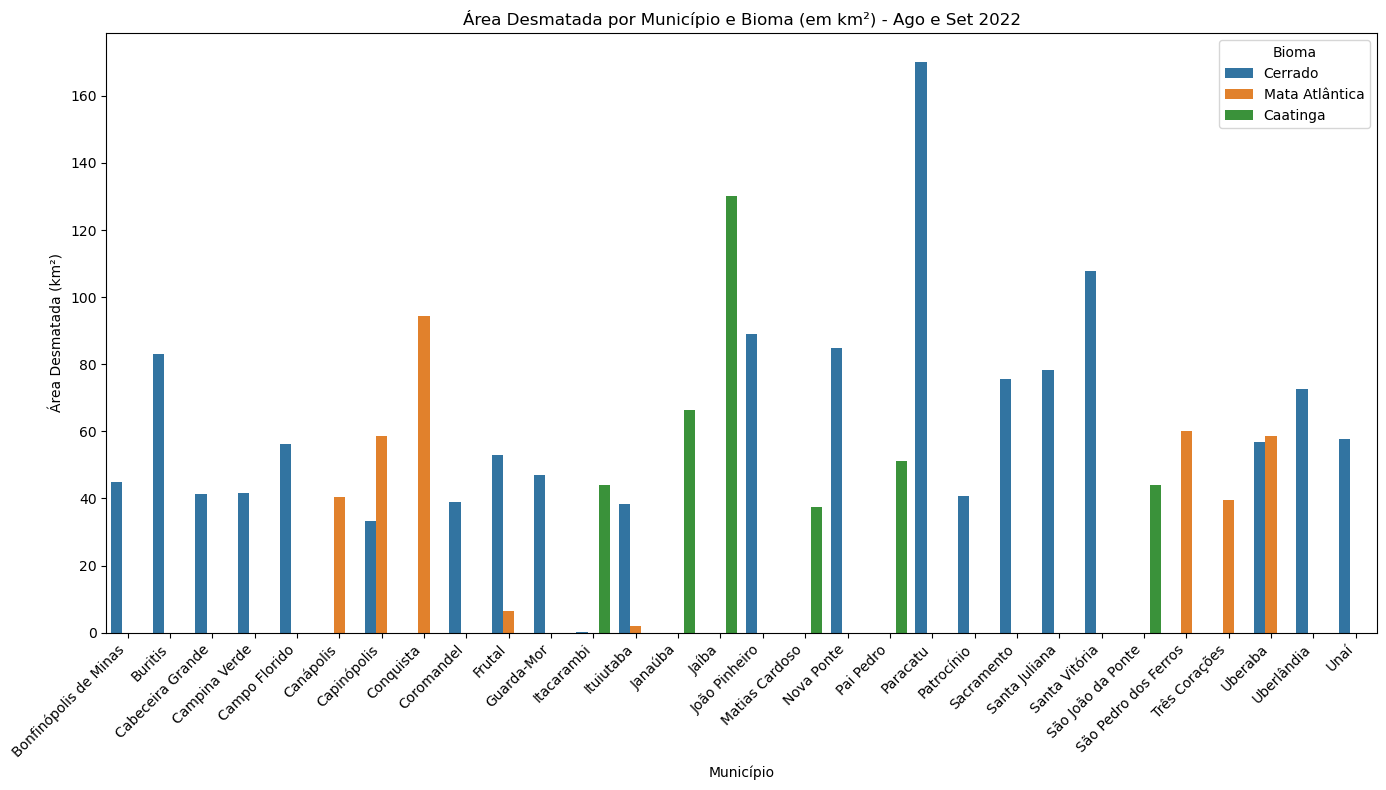

In [11]:
#Construir gráfico
plt.figure(figsize=(14, 8))
sns.barplot(data=top_30_data, x='name', y='area_km2', hue='Bioma', errorbar=None)

plt.title('Área Desmatada por Município e Bioma (em km²) - Ago e Set 2022')
plt.xlabel('Município')
plt.ylabel('Área Desmatada (km²)')
plt.xticks(rotation=45, ha='right')
plt.legend(title='Bioma')
plt.tight_layout()

plt.show()

### Desmatamento por município espacialmente explícito

In [24]:
import geopandas as gpd
import numpy as np
import matplotlib as mpl

In [34]:
# Carregar os limites dos municípios
municipios_file = f"{path}municipios-mg.geojson"
gdf_municipios = gpd.read_file(municipios_file)

# Carregar os dados de desmatamento
desmatamento_file = f"{path}interseccao_desmatamento_municipios.geojson"
gdf_desmatamento = gpd.read_file(desmatamento_file)

# Calcular a interseção e a área desmatada por município
gdf_interseccao = gpd.overlay(gdf_municipios, gdf_desmatamento, how='intersection', keep_geom_type=False)
gdf_interseccao['area_desmatada'] = gdf_interseccao.area / 1e6  # Convertendo para km²

In [35]:
# Identificar a coluna correta para o nome dos municípios
nome_coluna_municipio = 'name_1' if 'name_1' in gdf_interseccao.columns else 'name_2'

# Criar uma função de agregação que soma apenas colunas numéricas
def custom_aggfunc(series):
    if np.issubdtype(series.dtype, np.number):
        return series.sum()
    else:
        return series.iloc[0]

gdf_agrupado = gdf_interseccao.dissolve(
    by=nome_coluna_municipio,
    aggfunc=custom_aggfunc
)

# Adicionar a área desmatada ao GeoDataFrame dos municípios
gdf_municipios = gdf_municipios.set_index('name').join(gdf_agrupado[['area_desmatada']])

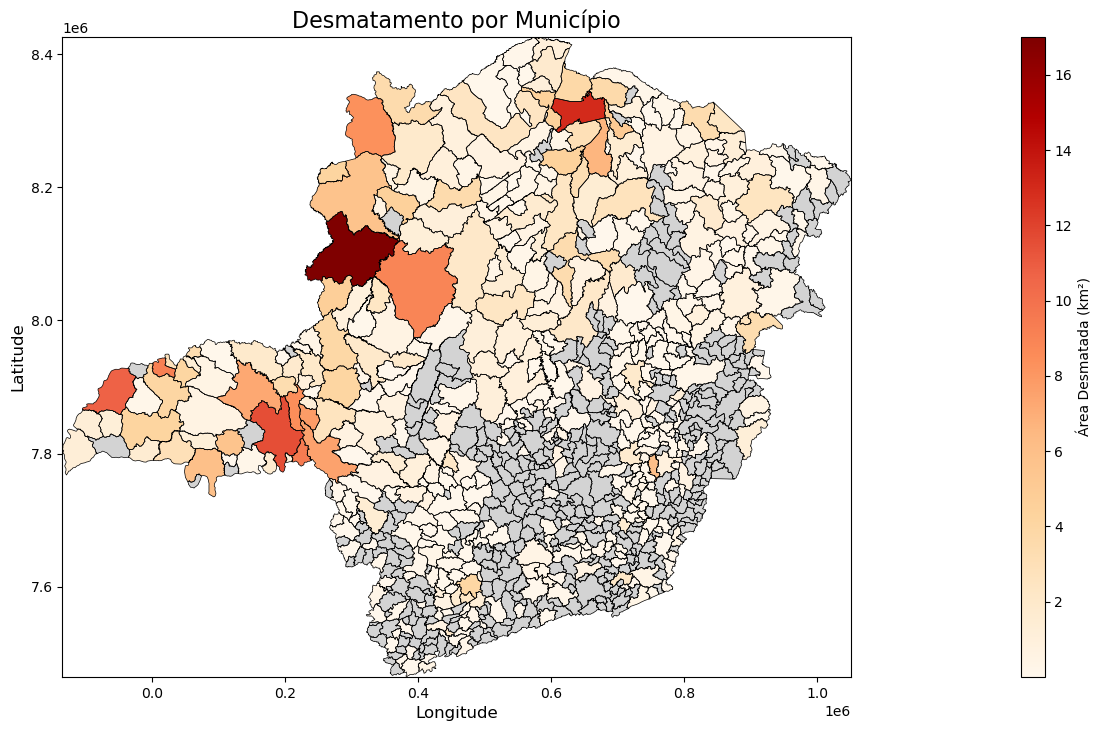

In [36]:
# Criar o mapa
fig, ax = plt.subplots(1, 1, figsize=(12, 8))
gdf_municipios.boundary.plot(ax=ax, linewidth=0.5, color='black')

cmap = 'OrRd'
norm = mpl.colors.Normalize(vmin=gdf_municipios['area_desmatada'].min(), vmax=gdf_municipios['area_desmatada'].max())
gdf_municipios.plot(column='area_desmatada', ax=ax, legend=False, cmap=cmap,
                    missing_kwds={'color': 'lightgrey'})

cbar = plt.cm.ScalarMappable(norm=norm, cmap=cmap)
cbar.set_array([])
cbar_ax = fig.add_axes([0.92, 0.1, 0.02, 0.8]) 
fig.colorbar(cbar, cax=cbar_ax, label='Área Desmatada (km²)')

ax.set_xlim(gdf_municipios.total_bounds[[0, 2]])
ax.set_ylim(gdf_municipios.total_bounds[[1, 3]])

plt.subplots_adjust(left=0.05, right=0.85, top=0.9, bottom=0.1)

ax.set_title('Desmatamento por Município', fontsize=16)
ax.set_xlabel('Longitude', fontsize=12)
ax.set_ylabel('Latitude', fontsize=12)

plt.savefig('desmatamento_municipios.tiff', dpi=300)

plt.show()

### Área desmatada por região

In [44]:
# Agrupar por município e somar as áreas desmatadas
area_por_regiao = df.groupby('NuFis')['area_km2'].sum().reset_index()
area_por_regiao = area_por_regiao.rename(columns={'NuFis': 'regiao'})

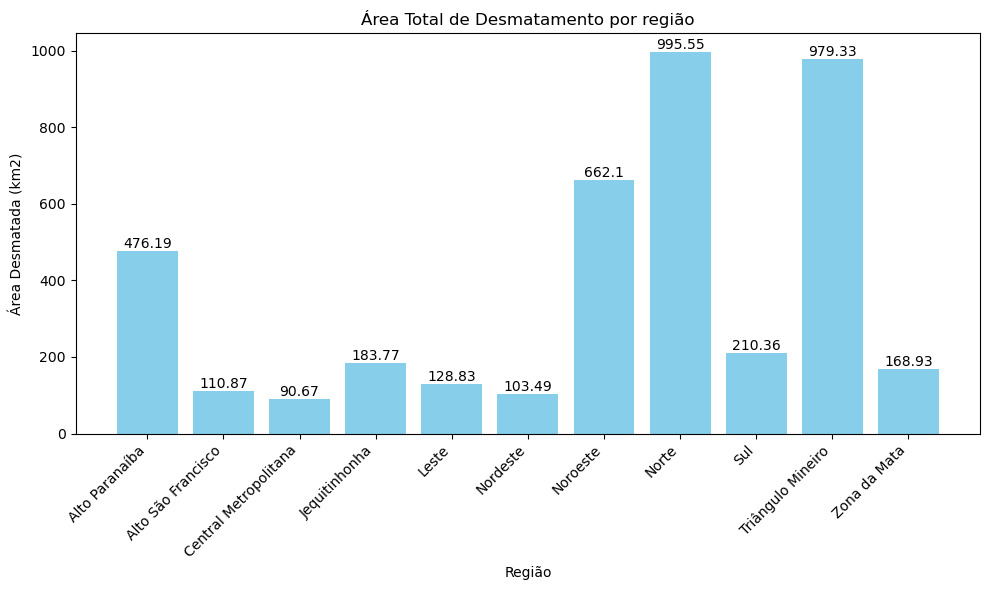

In [53]:
plt.figure(figsize=(10, 6))
bars = plt.bar(area_por_regiao['regiao'], area_por_regiao['area_km2'], color='skyblue')
plt.xlabel('Região')
plt.ylabel('Área Desmatada (km2)')
plt.title('Área Total de Desmatamento por região')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()

for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval, round(yval, 2), va='bottom', ha='center')

plt.show()

### Desmatamento relativo por município

In [46]:
import geopandas as gpd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt

In [47]:
path = 'D:/Projetos/Agronomiq/Teste_Adm/'

# Carregar os limites dos municípios
municipios_file = f"{path}municipios-mg.geojson"
gdf_municipios = gpd.read_file(municipios_file)

# Carregar os dados de desmatamento
desmatamento_file = f"{path}interseccao_desmatamento_municipios.geojson"
gdf_desmatamento = gpd.read_file(desmatamento_file)

# Calcular a interseção e a área desmatada por município
gdf_interseccao = gpd.overlay(gdf_municipios, gdf_desmatamento, how='intersection', keep_geom_type=False)
gdf_interseccao['area_desmatada'] = gdf_interseccao.area / 1e6  # Convertendo para km²

# Identificar a coluna correta para o nome dos municípios
nome_coluna_municipio = 'name_1' if 'name_1' in gdf_interseccao.columns else 'name_2'

In [48]:
# Criar uma função de agregação que soma apenas colunas numéricas
def custom_aggfunc(series):
    if np.issubdtype(series.dtype, np.number):
        return series.sum()
    else:
        return series.iloc[0]

# Agrupar por município e somar as áreas desmatadas
gdf_agrupado = gdf_interseccao.dissolve(
    by=nome_coluna_municipio,
    aggfunc=custom_aggfunc
)

gdf_municipios['area_total'] = gdf_municipios.area / 1e6  # Convertendo para km²

gdf_municipios = gdf_municipios.set_index('name').join(gdf_agrupado[['area_desmatada']])

gdf_municipios['percentual_desmatado'] = (gdf_municipios['area_desmatada'] / gdf_municipios['area_total']) * 100


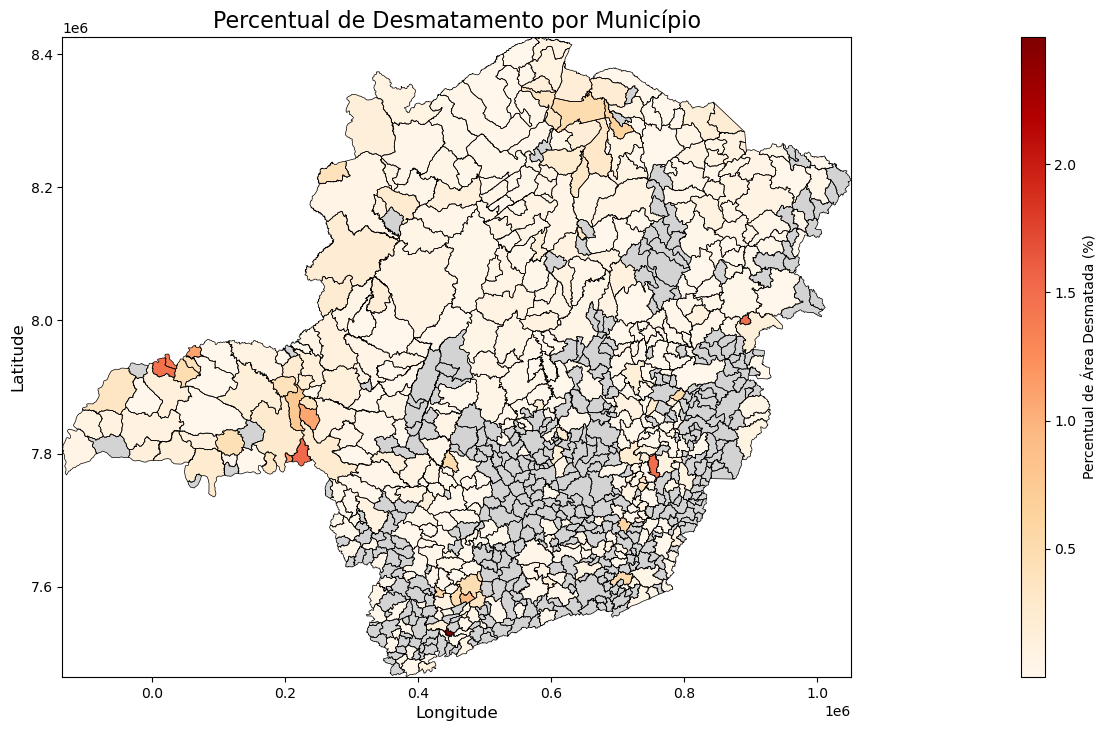

In [49]:
# Criar o mapa
fig, ax = plt.subplots(1, 1, figsize=(12, 8))
gdf_municipios.boundary.plot(ax=ax, linewidth=0.5, color='black')

cmap = 'OrRd'
norm = mpl.colors.Normalize(vmin=gdf_municipios['percentual_desmatado'].min(), vmax=gdf_municipios['percentual_desmatado'].max())
gdf_municipios.plot(column='percentual_desmatado', ax=ax, legend=False, cmap=cmap,
                    missing_kwds={'color': 'lightgrey'})

cbar = plt.cm.ScalarMappable(norm=norm, cmap=cmap)
cbar.set_array([])
cbar_ax = fig.add_axes([0.92, 0.1, 0.02, 0.8])
fig.colorbar(cbar, cax=cbar_ax, label='Percentual de Área Desmatada (%)')

ax.set_xlim(gdf_municipios.total_bounds[[0, 2]])
ax.set_ylim(gdf_municipios.total_bounds[[1, 3]])

plt.subplots_adjust(left=0.05, right=0.85, top=0.9, bottom=0.1)

ax.set_title('Percentual de Desmatamento por Município', fontsize=16)
ax.set_xlabel('Longitude', fontsize=12)
ax.set_ylabel('Latitude', fontsize=12)

plt.savefig('percentual_desmatamento_municipios.tiff', dpi=300)

plt.show()

### Municípios com percentual de área desmatada acima de 1%

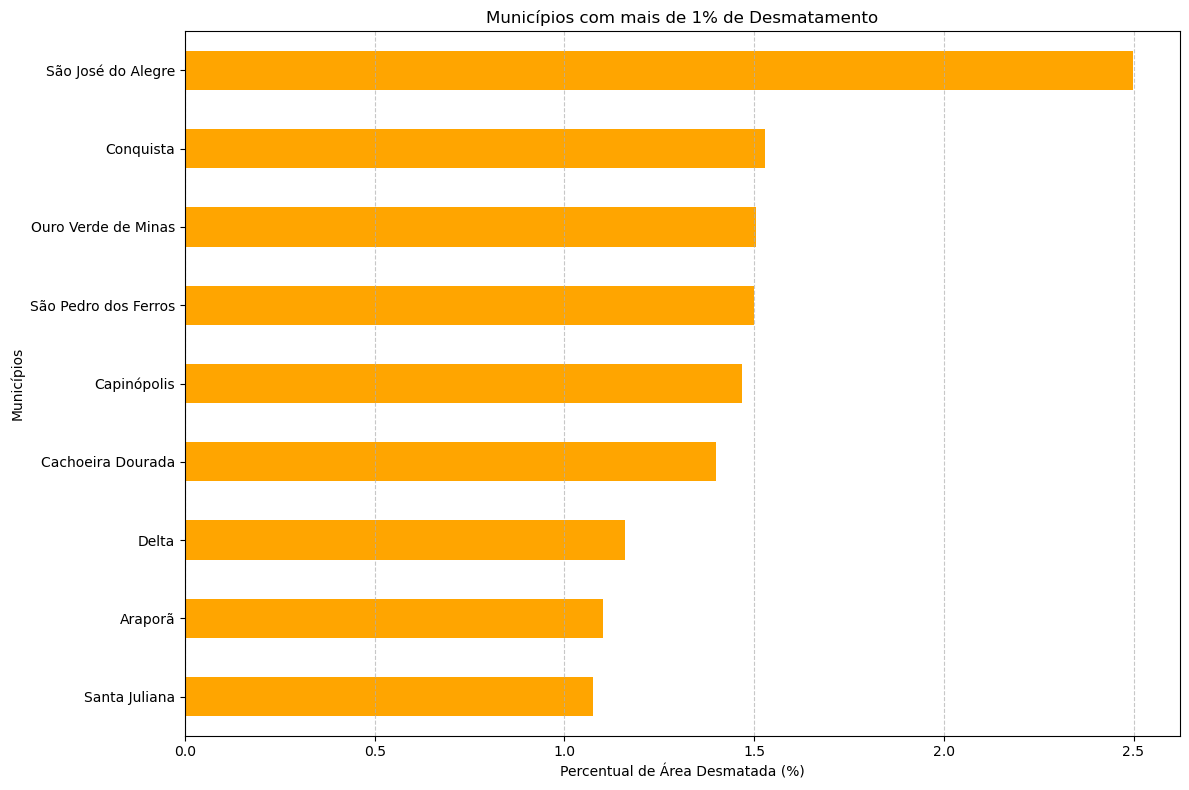

In [50]:
# Filtrar municípios com mais de 1% de desmatamento
municipios_desmatamento_acima_1 = gdf_municipios[gdf_municipios['percentual_desmatado'] > 1]

plt.figure(figsize=(12, 8))
municipios_desmatamento_acima_1['percentual_desmatado'].sort_values().plot(kind='barh', color='orange')
plt.title('Municípios com mais de 1% de Desmatamento')
plt.xlabel('Percentual de Área Desmatada (%)')
plt.ylabel('Municípios')
plt.grid(axis='x', linestyle='--', alpha=0.7)

plt.tight_layout()

plt.savefig('municipios_desmatamento_acima_1_porcento.png', dpi=300)

plt.show()